NOTE: This analysis is currently in process - check back again soon for more coffee info!

# The Caffeine Supply Chain: A Coffee Analysis Walkthrough

Coffee drinking is a global pastime, and its drinking population is growing.  In the U.S. alone, over 200 million people regularly drink an average of 3 cups of coffee per day <sup>1</sup>.  Over \\$225 Billion is spent on coffee in the United States, with consumers paying \\$75 Billion to consume coffee and nearly all of the other \\$150 Billion spent on the coffee supply chain.<sup>2</sup>

So where does this mountain of coffee come from?  Let's analyze some global coffee data and see what makes sense.

## Coffee Producers
Most of the world's coffee is produced between the Tropics of Cancer and Capricorn (about 23.4 degrees north/south latitude), which are the farthest points north and south of the equator where the sun can appear directly overhead.  This region is able to receive the most energy from the sun and also holds climates with many of the attributes ideal for coffee growing like "a rich soil, mild temperatures, lots of rain, a dry season, and shaded sun"<sup>3</sup>.

This region is known as the coffee belt<sup>4</sup>:
![Coffee Belt](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Bean_belt_%28top_20_coffee_producers_2011%29.svg/800px-Bean_belt_%28top_20_coffee_producers_2011%29.svg.png)

<br><sup>1</sup> https://nationalcoffee.blog/2018/09/26/by-the-numbers-us-coffee-consumption/
<br><sup>2</sup> http://www.ncausa.org/industry-resources/economic-impact
<br><sup>3</sup> https://www.deathwishcoffee.com/blogs/news/what-is-the-coffee-belt
<br><sup>4</sup> https://en.wikipedia.org/wiki/Coffee_bean

## Gathering our data

There are many sites that offer coffee statistics, but if we really want to dig into the details of how coffee flows along the supply chain, we will need to get our hands on some detailed data points.

The International Coffee Organization (ICO) is "the main intergovernmental organization for coffee, bringing together exporting and importing Governments to tackle the challenges facing the world coffee sector through international cooperation. Its Member Governments represent 98% of world coffee production and 67% of world consumption."<sup>1</sup>  Although ICO data does not comprehensively cover all coffee movements, it is the single greatest source of data regarding yearly coffee movements around the globe.  Let's start there.

- Let's go to the ICO site and find the "Historical Data" section.
![ICO Historical Data](img/ICO_historical_data.png)
<br>
<br>
- At first glance, it can be hard to understand how the data is organized.
![ICO Historical Data](img/ICO_historical_data2.png)
<br>
<br>
- We can easily see which data is gathered on a calendar basis vs. a seasonal basis ("crop year"), but it can be hard to initially understand which sub-sections refer to exporters vs. importers.  We will separate our data into "seasonal" and "calendar" data and the five types of commodity movements: Inventory + Production + Imports - Exports - Consumption.  We will also focus mostly on the "SOURCE" data, since this is originally reported data and any "CALC" data we should be able to calculate on our own.  We will include some imported consumption data for convenience:

```
Description                                 |File| Origin |Movement| Database Name
--------------------------------------------------------------------------------------------
Supply Data
- Total production - Crop Year              | 1A | SOURCE | export | seasonal_production
- Domestic consumption - Crop Year          | 1B | SOURCE | export | seasonal_consumption
- Exportable production - Crop Year         | 1C | CALC   | export | 
- Gross opening stocks - Crop Year          | 1D | SOURCE | export | seasonal_inventory
- Exports - Crop Year                       | 1E | SOURCE | export | seasonal_exports

Trade Statistics Data
- Exports - Calendar Year                   | 2A | SOURCE | export | calendar_exports
- Imports - Calendar Year                   | 2B | SOURCE | import | calendar_imports
- Re-exports - Calendar Year                | 2C | SOURCE | import | calendar_exports

Inventories/Consumption Data
- Inventories - End of Year                 | 4A | SOURCE | import | calendar_inventory
- Disappearance (consumption) - End of Year | 4B | CALC   | import | calendar_consumption

Non-Member Data
- Imports - Calendar Year                   | 5A | SOURCE | import | calendar_imports
- Re-exports - Calendar Year                | 5B | SOURCE | import | calendar_exports
```

<br><sup>1</sup> http://www.ico.org/mission07_e.asp?section=About_Us

## Setup our database

Before we can do any analysis we will need to set up our database.  We will use a PostgreSQL database on macOS.

Please [install PostgreSQL](https://www.postgresql.org/) if needed
Start the postgresql service, create the `coffee` database, and enter the postgres environment
```
brew services start postgresql
createdb coffee
psql coffee
```
Create the database admin and add privileges
```
CREATE USER coffeeadmin WITH PASSWORD [password];
GRANT ALL PRIVILEGES ON DATABASE coffee TO coffeeadmin;
GRANT ALL PRIVILEGES ON ALL TABLES IN SCHEMA public TO coffeeadmin;
```
We will need to convert text months and types of coffee to standardized IDs, so let's go ahead and manually create and fill these tables
```
CREATE TABLE month (id int PRIMARY KEY, title text);
GRANT ALL PRIVILEGES ON ALL TABLES IN SCHEMA public TO coffeeadmin;
INSERT INTO month (id, title) VALUES (1,'January');
INSERT INTO month (id, title) VALUES (2,'February');
INSERT INTO month (id, title) VALUES (3,'March');
INSERT INTO month (id, title) VALUES (4,'April');
INSERT INTO month (id, title) VALUES (5,'May');
INSERT INTO month (id, title) VALUES (6,'June');
INSERT INTO month (id, title) VALUES (7,'July');
INSERT INTO month (id, title) VALUES (8,'August');
INSERT INTO month (id, title) VALUES (9,'September');
INSERT INTO month (id, title) VALUES (10,'October');
INSERT INTO month (id, title) VALUES (11,'November');
INSERT INTO month (id, title) VALUES (12,'December');
```
```
CREATE TABLE coffee_type (id int, title text, symbol text);
GRANT ALL PRIVILEGES ON ALL TABLES IN SCHEMA public TO coffeeadmin;
INSERT INTO coffee_type (id, title, symbol) VALUES (1,'Arabica','(A)');
INSERT INTO coffee_type (id, title, symbol) VALUES (2,'Robusta','(R)');
INSERT INTO coffee_type (id, title, symbol) VALUES (3,'Both','(A/R)');
INSERT INTO coffee_type (id, title, symbol) VALUES (3,'Both','(R/A)');
```
The ICO location names are unique, but we probably want to create some tables that allow each location to have an ID and be compatible with a variety of text variations, due to language and other spelling differences we might encounter
```
CREATE TABLE location (id int PRIMARY KEY, title text, parent_location_id int);
CREATE TABLE location_name (location_id int, name text);
```
In the top directory is a `locations.xlsx` file I compiled with standardized location names, assigned location IDs, parent location IDs (allows us to nest locations for grouped analysis), and a list of possible variations on the location name which also include all name versions used by the ICO data.  This allows us to standardize all locations and even combine this data with other data sources later, if needed.  Let's write a Python script to pull the locations out of this Excel file and add them to the database

Remember to grant our admin account access to the new tables.
```
GRANT ALL PRIVILEGES ON ALL TABLES IN SCHEMA public TO coffeeadmin;
```

The script to import the locations and location names is relatively simple. . .

In [ ]:
wb = open_workbook('locations.xlsx')
    for s in wb.sheets():
        print('Sheet: %s' % (s.name))
        if s.name == 'ALL':
            for row in range(1, s.nrows):
                id = int(s.cell(row, 0).value)
                parent = int(s.cell(row, 1).value)
                location = s.cell(row, 2).value
                names = tuple(s.cell(row, 3).value.split('|'))
                query = ("INSERT INTO location"
                         " (id,parent_location_id,title)"
                         " VALUES (%s, %s, %s)"
                         " RETURNING id")
                sql(query, id, parent, location)
                for name in names:
                    query = ("INSERT INTO location_name"
                             " (location_id,name)"
                             " VALUES (%s, %s)"
                             " RETURNING location_id")
                    sql(query, id, name)

. . .but we will need some support methods, so let's just use it from within the `utils` file.

```
MacBook-Air:src seanhart$ python3
Python 3.7.5 (default, Nov  1 2019, 02:16:32) 
[Clang 11.0.0 (clang-1100.0.33.8)] on darwin
Type "help", "copyright", "credits" or "license" for more information.
>>> 
>>> import utils
>>> utils.locations_to_db()
Sheet: ALL
Sheet: STANDARD
>>> 
>>> exit()
```

Now let's check that all of the locations were processed.  We should have 206 locations and almost 250 variations on location names.

```
psql coffee
coffee=# SELECT COUNT(*) FROM location;
 count 
-------
   206
(1 row)

coffee=# 
coffee=# 
coffee=# SELECT COUNT(*) FROM location_name;
 count 
-------
   248
(1 row)
```

Ok, that looks correct.  Let's move on to importing the supply chain data.

## Import ICO data

We need to extract the data from the ICO Excel files.

We will need to create tables for each of the major movement types (inventory, production, imports, exports, consumption) for both seasonal and calendar data.  Seasonal data includes the harvest month and coffee type so let's add those columns in case we want to distinguish via those data points later.
```
CREATE TABLE seasonal_inventory (id text PRIMARY KEY, year int, harvest_month_id int, location_id int, coffee_type int, value float);
CREATE TABLE seasonal_production (id text PRIMARY KEY, year int, harvest_month_id int, location_id int, coffee_type int, value float);
CREATE TABLE seasonal_exports (id text PRIMARY KEY, year int, harvest_month_id int, location_id int, coffee_type int, value float);
CREATE TABLE seasonal_consumption (id text PRIMARY KEY, year int, harvest_month_id int, location_id int, coffee_type int, value float);

CREATE TABLE calendar_inventory (id text PRIMARY KEY, year int, location_id int, value float);
CREATE TABLE calendar_imports (id text PRIMARY KEY, year int, location_id int, value float);
CREATE TABLE calendar_exports (id text PRIMARY KEY, year int, location_id int, value float);
CREATE TABLE calendar_consumption (id text PRIMARY KEY, year int, location_id int, value float);
```
Remember to grant our admin account access to the new tables.
```
GRANT ALL PRIVILEGES ON ALL TABLES IN SCHEMA public TO coffeeadmin;
```

Now let's create and run the scripts to import the Excel data from ICO.  We will access the Excel files from the links directly so we can simply call the scripts in the future when we want to update the data.

(Note that the scripts call a local `utils` file that contains some commonly used methods including the basic SQL query method that will access our database using the `psycopg2` library.)

Here are the scripts we will use (in the `/data_parse` directory), but skip below and we will run them from the terminal for ease.

. . . seasonal extract script coming soon . . .

In [ ]:
from .. import utils


# Excel sheet links
link_importers_inventory = 'http://www.ico.org/historical/1990%20onwards/Excel/4a%20-%20Inventories.xlsx'
link_importers_imports = 'http://www.ico.org/historical/1990%20onwards/Excel/2b%20-%20Imports.xlsx'
link_importers_other_imports = 'http://www.ico.org/historical/1990%20onwards/Excel/5a%20-%20Non-member%20imports.xlsx'
link_importers_exports = 'http://www.ico.org/historical/1990%20onwards/Excel/2c%20-%20Re-exports.xlsx'
link_importers_other_exports = 'http://www.ico.org/historical/1990%20onwards/Excel/5b%20-%20Non-member%20re-exports.xlsx'
link_importers_consumption = 'http://www.ico.org/historical/1990%20onwards/Excel/4b%20-%20Disappearance.xlsx'

# The first column will be the location names
# The second column will start the data
location_col = 0
value_col = 1

# Store the data in a local dict to sum any split locations
# data is stored in id:value format
data = {}


def calendar_data_update(link, sheet_name, db_name):
    # Reset the dict
    data = {}
    print('data length: %d' % len(data))

    # Get the workbook from the link
    wb = utils.get_workbook_at(link)

    # Find the correct sheet in the workbook
    sheet = find_sheet(wb, sheet_name)

    # Find the first row that is not blank
    topRow = find_data_start_row(sheet, 1)

    for col in range(value_col, sheet.ncols):
        # First get the calendar year - it will be two years,
        # so grab the first two numbers for century
        # and last two numbers for year
        year = int(sheet.cell(topRow, col).value)

        # Grab the location data on each row for this year
        # skip the header row
        for row in range(topRow+1, sheet.nrows):

            # If the cell contains the word 'inventories'
            # or is empty it is not a countable cell
            inventories_text_start = sheet.cell(row, location_col).value.find('Inventories')
            if inventories_text_start == -1 and sheet.cell(row, location_col).value != "":

                # If you get to the 'Total' row, stop
                if sheet.cell(row, location_col).value == 'Total':
                    break

                # If the first column might have two spaces at the beginning
                # of the cell - be sure to clean up the text
                location_name = sheet.cell(row, location_col).value
                location_name = location_name.strip()
                # print(location_name)

                # Find the location id based off of the used name
                location_result = utils.sql("SELECT location_id FROM location_name WHERE name=%s", location_name)
                # Raise error and skip if the location cannot be found
                if len(location_result) < 1:
                    print("ERROR - LOCATION '%s' NOT FOUND" % (location_name))
                    continue

                # If the results have more than one tuple, we have duplicate location names
                if len(location_result[0]) != 1:
                    print("ERROR - LOCATION '%s' ENTRY ERROR" % (location_name))
                    continue

                location_id = location_result[0][0]
                # print(location_id)
                id = '%d-%d' % (location_id, year)

                # Check to ensure the value is not empty, if so assign 0
                value = float(0)
                if sheet.cell(row, col).value != '':
                    value = float(sheet.cell(row, col).value)

                # Get the value to use after checking for split locations
                value = calculate_location_total(id, value)
                # print("%s, %d, %d, %d" % (id, year, location_id, value))

                insert = ("INSERT INTO " + db_name +
                          " (id,year,location_id,value)"
                          " VALUES (%s, %s, %s, %s)"
                          " ON CONFLICT ON CONSTRAINT " + db_name + "_pkey"
                          " DO UPDATE SET value=%s"
                          " RETURNING id")
                utils.sql(insert, id, year, location_id, value, value)


# If a location has been split over several location names
# the values will need to be summed
def calculate_location_total(id, value):
    # Check whether the id already exists - if it does,
    # sum the previous value with the new value and
    # return the new total value for overwriting the old value
    new_value = 0
    if id in data:
        print('%s: %f' % (id, value))
        new_value = data[id] + value
    else:
        new_value = value

    # Record the entry in the data dict
    data[id] = new_value
    return new_value


def find_data_start_row(sheet, column):
    # Find the first row in the passed column with the passed text
    for row in range(sheet.nrows):
        if sheet.cell(row, column).value != '':
            return row


def find_sheet(workbook, sheet_name):
    for s in workbook.sheets():
        print('Sheet: %s' % (s.name))
        if s.name == sheet_name:
            return s


if __name__ == "__main__":
    print("calendar update")
    calendar_data_update(link_importers_inventory, 'Inventories', 'calendar_inventory')
    data = {}  # Reset the dict
    calendar_data_update(link_importers_imports, 'Imports', 'calendar_imports')
    data = {}  # Reset the dict
    calendar_data_update(link_importers_other_imports, 'Imports', 'calendar_imports')
    data = {}  # Reset the dict
    calendar_data_update(link_importers_exports, 'Re-exports', 'calendar_exports')
    data = {}  # Reset the dict
    calendar_data_update(link_importers_other_exports, 'Re-exports', 'calendar_exports')
    data = {}  # Reset the dict
    calendar_data_update(link_importers_consumption, 'Disappearance', 'calendar_consumption')
    data = {}  # Reset the dict


Run the calendar data import script (using the `-m` flag to use the Python module namespace) from the package root directory:
```
MacBook-Air:coffee seanhart$ python3 -m src.data_parse.calendar
```

Now let's check our database and see if the data was imported correctly.
```
MacBook-Air:coffee seanhart$ psql coffee
psql (12.1)
Type "help" for help.

coffee=# \d
                List of relations
 Schema |         Name         | Type  |  Owner   
--------+----------------------+-------+----------
 public | calendar_consumption | table | seanhart
 public | calendar_exports     | table | seanhart
 public | calendar_imports     | table | seanhart
 public | calendar_inventory   | table | seanhart
 public | coffee_type          | table | seanhart
 public | location             | table | seanhart
 public | location_name        | table | seanhart
 public | month                | table | seanhart
 public | seasonal_consumption | table | seanhart
 public | seasonal_exports     | table | seanhart
 public | seasonal_inventory   | table | seanhart
 public | seasonal_production  | table | seanhart
(12 rows)

coffee=# SELECT * FROM calendar_consumption WHERE year=2018 ORDER BY location_id DESC LIMIT 5;
    id    | year | location_id | value 
----------+------+-------------+-------
 100-2018 | 2018 |         100 |    29
 99-2018  | 2018 |          99 |    87
 98-2018  | 2018 |          98 |   715
 97-2018  | 2018 |          97 |     0
 96-2018  | 2018 |          96 |     0
(5 rows)
```

We can run the same test but join with the location table to show the location titles
```
coffee=# SELECT lid.title AS location,pid.title AS parent,cons.year,cons.value AS consumption
coffee-# FROM calendar_consumption cons
coffee-# INNER JOIN location lid ON cons.location_id=lid.id
coffee-# INNER JOIN location pid ON lid.parent_location_id=pid.id
coffee-# WHERE year=2018 ORDER BY location_id ASC LIMIT 5;
  location   |   parent   | year |    consumption     
-------------+------------+------+--------------------
 EU          | Europe     | 2018 |       44729.571005
 Japan       | Asia-North | 2018 |       7833.5956675
 Norway      | Europe     | 2018 |        734.1667393
 Russia      | Asia-North | 2018 |       4233.5037736
 Switzerland | Europe     | 2018 | 1170.2869719999999
(5 rows)
```

We can run similar test queries on all the tables and see the data appears to be formatted correctly, and if we double-check some random rows with the Excel file the data appears to be accurate.  For additional checking, we can also run tests on the totals for each table (by year) and compare to the Excel file, if desired.

(Please note that imports and exports include both the regular imports/exports files and the "other" imports/exports files, so each database table total will include the sum of both file totals.)
```
coffee=# SELECT year,SUM(value) FROM calendar_consumption GROUP BY year ORDER BY year;
 year |        sum         
------+--------------------
 1990 |  93551.86161529997
 1991 | 101593.80189780003
 1992 | 103121.07931870001
 1993 | 108995.99266259998
 1994 | 100591.84517909998
 1995 | 104327.99943299996
 1996 | 106821.23959110002
 1997 | 105876.65767690002
 1998 | 107891.48143409999
 1999 | 107384.10738219999
 2000 | 105611.71093510001
 2001 |     108461.2095811
 2002 | 109274.60534609997
 2003 | 112721.15981410001
 2004 |     116346.4352132
 2005 | 113095.83543549998
 2006 |     116182.3202563
 2007 |     116589.1928358
 2008 | 115930.80449770001
 2009 |     113732.1700961
 2010 |     117126.2707015
 2011 | 116561.26319139998
 2012 |      117207.713997
 2013 |             119985
 2014 |      80296.5465616
 2015 |      80318.9926862
 2016 |      84482.4657011
 2017 |      82270.6014287
 2018 |      85748.2519519
(29 rows)
```

Now let's take a look at some aggregate data and see if we have a complete picture of the supply chain.  It is likely that we have some "holes" in our data and will need to make some assumptions to analyze the market as a whole.

In most of the remaining analyses, we will use Python to call our SQL queries so that we can utilize other Python analysis tools.  We will use the `connect` file methods to set up our queries so we do not need to repeat unnecessary code in this notebook.

In [2]:
import sys
sys.path.append('../')
import pandas as pd
from matplotlib import pyplot as plt
from src import connect
conn = connect.connect()
colors = ["#839B7F","#A5A181","#B18558","#2B1504","#00494F"]

## Supply Chain Measurement Variance

In a supply chain, the [inventory] + [inputs] - [outputs] should = the next cycle's [inventory].  If not, we should take note of the discrepancy to be sure it does not affect any analysis method.

That said, in the real world measurement variances and tolerated losses will always result in slight discrepancies.  If the calculated inventory ever matches the reported inventory, this is a sign that the data somewhere was not measured, but instead was calculated.

Every industry and company will have a standard for accepted variances in measurement and should conduct investigations when losses (or gains) exceed that standard tolerance range.

### Inputs

We will investigate the importers data by starting with the imports and get an overview of where our coffee is being shipped each year.

Europe is a fairly large importer of coffee, let's see how much coffee they received in 2018.

                  location  parent      imports
0                   Norway  Europe   743.340422
1              Switzerland  Europe  3086.018913
2                  Albania  Europe   125.000000
3                  Belarus  Europe   383.000000
4   Bosnia and Herzegovina  Europe   403.000000
5                  Georgia  Europe   193.000000
6                Gibraltar  Europe     3.000000
7                 Holy See  Europe     0.000000
8                  Iceland  Europe    51.000000
9                  Moldova  Europe    61.000000
10              Montenegro  Europe    59.000000
11         North Macedonia  Europe   159.000000
12                  Serbia  Europe   550.000000
13                 Ukraine  Europe  1338.000000
14              Yugoslavia  Europe     0.000000


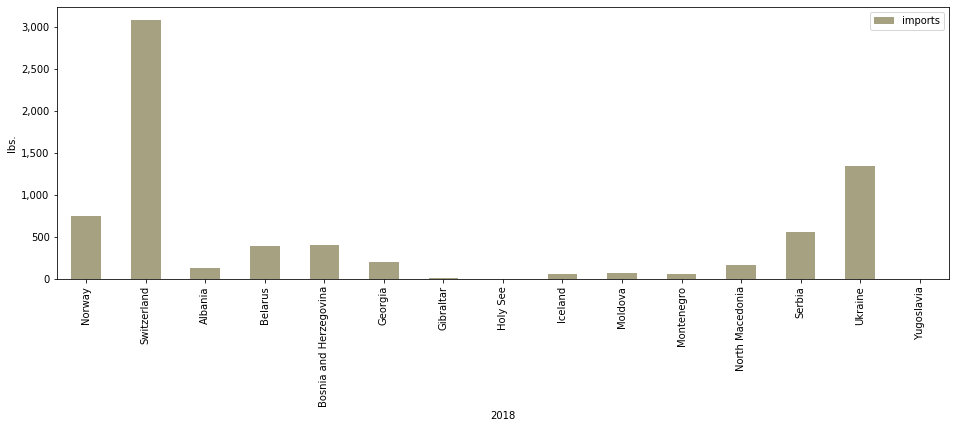

In [49]:
df = pd.read_sql("""SELECT lid.title AS location,pid.title AS parent,i.value AS imports
FROM calendar_imports i
INNER JOIN location lid ON i.location_id=lid.id
INNER JOIN location pid ON lid.parent_location_id=pid.id
WHERE (year=2018 AND pid.title LIKE '%Europe%') AND NOT lid.title='EU'
ORDER BY location_id ASC;""",conn)
print(df)
b = df.plot.bar(figsize=(16,5), color=colors[1])
b.set_yticklabels([f'{x:,.0f}' for x in b.get_yticks()])
b.set_xticklabels(df['location'].tolist(), rotation=90)
b.set_ylabel("lbs.")
l = b.set_xlabel("2018")

These measurements are all in units of 60kg. bags, so let's convert everything to lbs. for now.

60 kgs. = 132.277 lbs.

                  location  parent        imports
0                   Norway  Europe   98326.841001
1              Switzerland  Europe  408209.323768
2                  Albania  Europe   16534.625000
3                  Belarus  Europe   50662.091000
4   Bosnia and Herzegovina  Europe   53307.631000
5                  Georgia  Europe   25529.461000
6                Gibraltar  Europe     396.831000
7                 Holy See  Europe       0.000000
8                  Iceland  Europe    6746.127000
9                  Moldova  Europe    8068.897000
10              Montenegro  Europe    7804.343000
11         North Macedonia  Europe   21032.043000
12                  Serbia  Europe   72752.350000
13                 Ukraine  Europe  176986.626000
14              Yugoslavia  Europe       0.000000


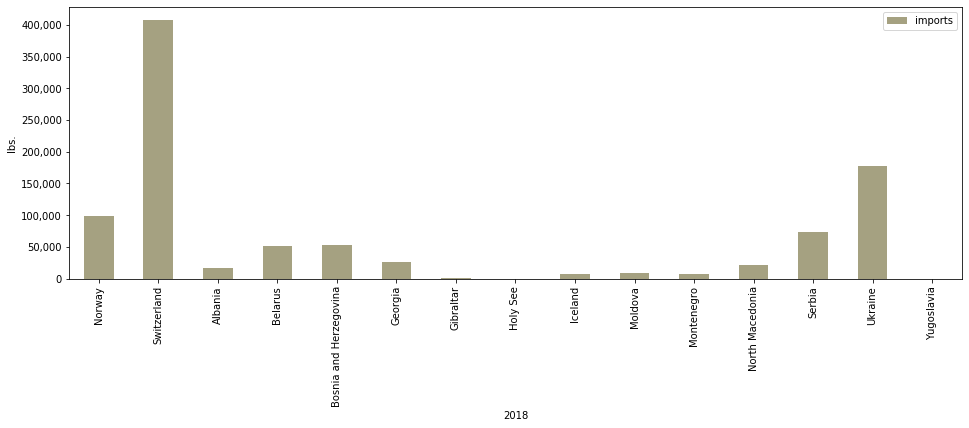

In [48]:
df = pd.read_sql("""SELECT lid.title AS location,pid.title AS parent,i.value * 132.277 AS imports
FROM calendar_imports i
INNER JOIN location lid ON i.location_id=lid.id
INNER JOIN location pid ON lid.parent_location_id=pid.id
WHERE (year=2018 AND pid.title LIKE '%Europe%') AND NOT lid.title='EU'
ORDER BY location_id ASC;""",conn)
print(df)
b = df.plot.bar(figsize=(16,5), color=colors[1])
b.set_yticklabels([f'{x:,.0f}' for x in b.get_yticks()])
b.set_xticklabels(df['location'].tolist(), rotation=90)
b.set_ylabel("lbs.")
l = b.set_xlabel("2018")

There we go.  Wow, Switzerland imports a lot!

Let's turn our attention to the United States for a bit and see how many pounds of coffee we have imported over the last 10 years of data.

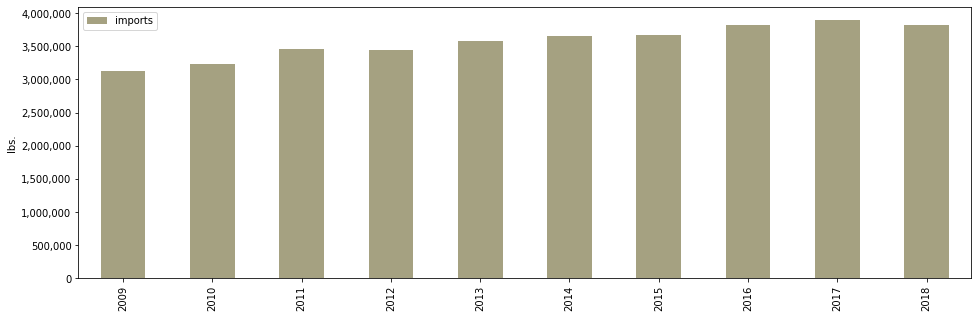

In [46]:
df = pd.read_sql("""SELECT lid.title AS location,i.year,i.value * 132.277 AS imports
FROM calendar_imports i
INNER JOIN location lid ON i.location_id=lid.id
WHERE year>2008 AND lid.title LIKE '%USA%'
ORDER BY location_id ASC;""",conn)
# b = df.plot.bar(figsize=(16,5), color=colors[1])
b = df.loc[:,['imports']].plot.bar(color=colors[1], figsize=(16,5))
b.set_yticklabels([f'{x:,.0f}' for x in b.get_yticks()])
b.set_xticklabels(df['year'].tolist(), rotation=90)
l = b.set_ylabel("lbs.")

The U.S. imports almost 10 times as much coffee as Switzerland!  Although if we think about that, we probably should have expected more.

Overall we see a steady increase in imports over the years, likely due to a growing population, although we can look into that in more detail at a later time.
<br>
<br>
<br>
Let's go ahead and add all components to the supply chain (inventory, imports, exports, consumption) and see the total coffee movement in the United States in recent years.

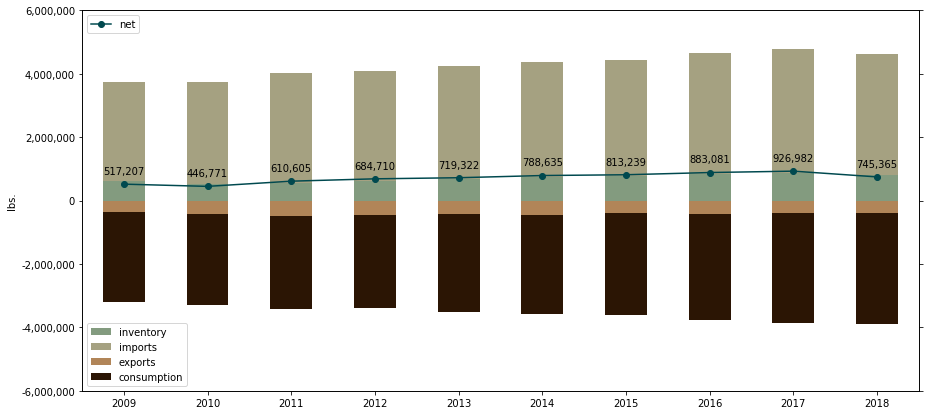

In [44]:
df = pd.read_sql("""SELECT l.title, cal3.year, cal3.inventory * 132.277 AS inventory, cal3.imports * 132.277 AS imports, cal3.exports * 132.277 AS exports, cal3.consumption * 132.277 AS consumption, (cal3.inventory + cal3.imports + cal3.exports + cal3.consumption) * 132.277 AS net
FROM location l 
INNER JOIN
    (
        SELECT cons.location_id, cons.year, cal2.inventory, cal2.imports, cal2.exports, 
            CASE 
                WHEN cons.value > 0 THEN cons.value * -1 
            END AS consumption 
        FROM calendar_consumption cons 
        INNER JOIN
            (
                SELECT inv.location_id, inv.year, inv.value as inventory, cal.imports, cal.exports 
                FROM calendar_inventory inv 
                INNER JOIN
                    (
                        SELECT ci.location_id, ci.year, ci.value AS imports,  
                            CASE  
                                WHEN ce.value > 0 THEN ce.value * -1 
                            END AS exports 
                        FROM calendar_imports ci 
                        INNER JOIN calendar_exports ce ON ci.location_id=ce.location_id AND ci.year=ce.year
                    ) AS cal
                ON cal.location_id=inv.location_id AND inv.year=cal.year
            ) AS cal2
        ON cal2.location_id=cons.location_id AND cons.year=cal2.year
    ) AS cal3
ON cal3.location_id=l.id
WHERE l.title='USA' AND cal3.year>2008
ORDER BY cal3.year ASC;""",conn)
b1=df.loc[:,['inventory','imports','exports','consumption']].plot.bar(stacked=True, color=colors, figsize=(15,7))
b1.set_xticklabels(df['year'].tolist(), rotation=0)
b1.set_yticklabels([f'{x:,.0f}' for x in b1.get_yticks()])
b1.set_ylim([min(b1.get_yticks()),max(b1.get_yticks())])
b1.legend(loc='lower left')
b1.set_ylabel("lbs.")
l1 = b1.twinx()
l1.set_yticklabels([])
l1.set_ylim([min(b1.get_yticks()),max(b1.get_yticks())])
l1.plot(b1.get_xticks(), df['net'], label='net', marker='o', color=colors[4])
l1.legend(loc='upper left')
for i,x in enumerate(df['net']):
    label = f'{x:,.0f}'
    l1.annotate(label,
                (i,x),
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center

At first glance, it appears that Exports (re-Exports) barely fluctuate, and Inventory grows a bit.  Imports and Consumption grow the most, which is expected, but also points to the fact that green coffee prices in the US are likely to fluctuate a good deal since they do not have a large buffer in the form of inventory or exports to relieve some of that volatility.
<br><br><br><br>
More analysis coming soon! . . .